# DCGANによる画像生成
今さら聞けないGANシリーズ第2回  
https://qiita.com/triwave33/items/35b4adc9f5b41c5e8141

## 全結合型GANの問題点
基本構造を少し変更するだけで，GANの画像生成の性能をアップさせられる  
  
ここでは，ピクセル単位のノイズを除去したい．  
全結合によるGANは28\*28=784の一列のデータとして扱っているため，各ピクセルは独立してしまっており，ピクセル間の関係性を表現できないことが原因．  

## 対策
CNNを使う．  
Generator, DiscriminatorのネットワークをCNNに変える．  
これをDeep Convolutional GAN, DCGANと呼ぶ．

## 実装テクニック


## 気にすること
基本のGANから何を差し替えたのかを意識する  
- ネットワーク構造
- 損失関数
- optimizer
- 入力するデータ
- 正解ラベル

In [1]:
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Input, Dense, BatchNormalization, Activation
from keras.layers import LeakyReLU, Dropout, Reshape, Flatten
from keras.layers import UpSampling2D, Convolution2D
from gan import GAN

class DCGAN(GAN):
    def build_generator(self):
        noise_shape = (self.latent_dim,)
        model = Sequential()
        model.add(Dense(1024, input_shape=noise_shape))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='relu1'))
        model.add(Dense(128*7*7))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='relu2'))
        model.add(Reshape((7, 7, 128), input_shape=(128*7*7, )))
        model.add(UpSampling2D((2, 2)))
        model.add(Convolution2D(64, 5, 5, border_mode='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='relu3'))
        model.add(UpSampling2D((2,2)))
        model.add(Convolution2D(1, 5, 5, border_mode='same'))
        model.add(Activation('tanh', name="tanh"))
        model.summary()
        return model
    
    def build_discriminator(self):
        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()
        model.add(Convolution2D(64, 5, 5, subsample=(2, 2), \
                           border_mode='same', input_shape=img_shape))
        model.add(LeakyReLU(0.2))
        model.add(Convolution2D(128, 5, 5, subsample=(2, 2)))
        model.add(LeakyReLU(0.2))
        model.add(Flatten())
        model.add(Dense(256))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.5))
        model.add(Dense(1))
        model.add(Activation('sigmoid', name="sigmoid"))
        model.summary()    
        return model

Using TensorFlow backend.


In [2]:
optimizer = Adam(lr=1e-5, beta_1=0.1) # DCGANではこっちの方がうまくいくらしい
dcgan = DCGAN(optimizer=optimizer, img_dir="images/dcgan")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_1 (Dense)      

d:\programming\machinelearning\keras\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(28, 28, 1..., strides=(2, 2), padding="same")`
d:\programming\machinelearning\keras\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), strides=(2, 2))`
d:\programming\machinelearning\keras\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
d:\programming\machinelearning\keras\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (5, 5), padding="same")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              103424    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
relu1 (Activation)           (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_2 (Batch (None, 6272)              25088     
_________________________________________________________________
relu2 (Activation)           (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
__________

Visualize: Discriminator


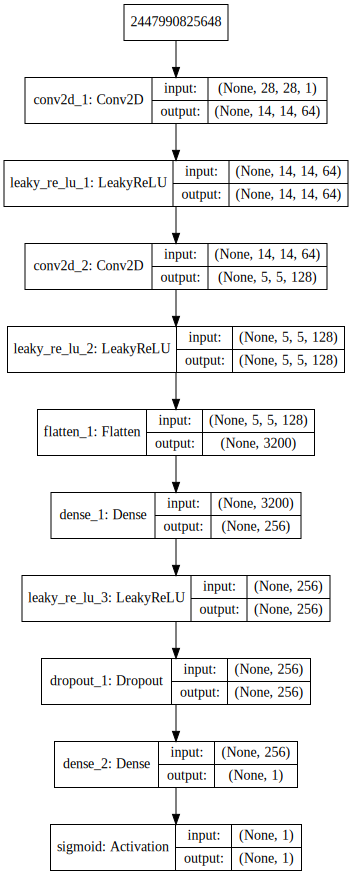

In [3]:
dcgan.visualize_discriminator()

Visualize: Generator


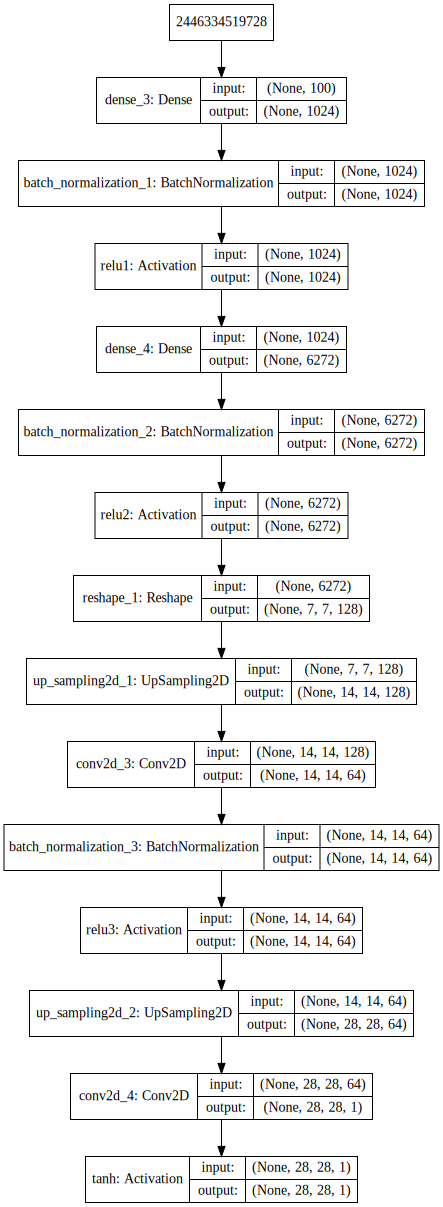

In [4]:
dcgan.visualize_generator()

Visualize: Combined


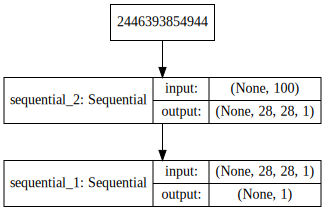

In [5]:
dcgan.visualize_combined()

In [ ]:
# 基本のGANの4倍近くのニューロン数なので，電気代的におうちのPCではあきらめ
dcgan.train(epochs=30000, batch_size=32, save_interval=3000)

初回3000エポック目にして結構いい感じの画像を出力してくれた．